# Infinite Latent Feature Models and the Indian Buffet Process

### 1) Outline

####a) Definition of Indian Buffet Process (IBP)

In the Indian buffet process, N customers enter a restaurant one after another. Each customer encounters a buffet consisting of infinitely many dishes arranged in a line. The first customer starts at the left of the buffet and takes a serving from each dish, stopping after a Poisson(α) number of dishes. The ith customer moves along the buffet, sampling dishes in proportion to their popularity, taking dish k with probability mk/i , where mk is the number of previous customers who have sampled that dish. Having reached the end of all previous sampled dishes, the ith customer then tries a Poisson(α/i) number of new dishes.

####b) Steps

1) Start by defining a probability distribution over equivalence classes of binary matrices with a finite number of rows and an unbounded number of columns. This distribution is suitable for use as a prior in probabilistic models that represent objects using a potentially infinite array of features

2) Next we see that the Indian Buffet Process is a simple generative process that results in the same distribution (as described in previous step) over equivalence classes because IBP has finite number of objects (people) and infinite number of features (dishes)

3) We then define a Gibbs Sampler for models using this concept of IBP

4) Further, to illustrate how IBP can be used as a prior in models for unsupervised learning, we derive and test a linear-Gaussian latent feature model in which the features are binary

5) We start with a finite realization and then take the infinite limit

###2) Algorithm/Pseudocode:

1) We use Gamma prior for $\alpha$
$$
\alpha \sim Gamma(1,1)
$$
2) Prior on Z is obtained by IBP (after taking the infinite limit) as:
$$
P(z_{ik}=1|\textbf{z}_{-i,k}) = \frac{m_{-i,k}}{N}
$$
where ${z}_{-i,k}$ is the set of assignments of other objects, not including i, for feature k, and
${m}_{-i,k}$ is the number of objects possessing feature k, not including i.
 
3) Likelihood is given by
\begin{equation}
P(X|Z,\sigma_X,A) = \frac{1}{(2 \pi \sigma_x^2)^{ND/2}}exp(-\frac{1}{2\sigma_X^2}tr((X-ZA)^T(X-ZA)))
\end{equation}
where Z is the binary feature matrix and A is the weight matrix. $\sigma_X$ and $\sigma_A$ are the respective noise terms.
Next, we integrate out A to get $P(X|Z,\sigma_X,\sigma_A)$.
 
4) Using this likelihood and the prior given by IBP, full conditional posterior for Z can be calculated as:
$$
P(z_{ik}|X,Z_{-(i,k)},\sigma_X,\sigma_A) \propto  P(X|Z,\sigma_X,\sigma_A) * P(z_{ik}=1|\textbf{z}_{-i,k})
$$
 
5) Now, to sample the number of new features for observation $i$, we use a truncated distribution, computing probabilities for a range of values $K_1^{(i)}$ up to an upper bound. The prior on number of features is given by $Poisson(\frac{\alpha}{N})$.
Using this prior and the likelihood, we sample the number of new features.
 
6) Conditional posterior for $\alpha$ is given by:
$$
P(\alpha|Z) \sim Gamma(1+K_+,1+\sum_{i=1}^{N} H_i)
$$
where $H_N$ is the Nth harmonic number given by $H_N=\sum_{j=1}^{N} 1/j$
 
7) We now run the Gibbs Sampler using these full conditionals

8) To update $\sigma_X$ and $\sigma_A$, we use MH algorithm as follows:
\begin{eqnarray}
\epsilon \sim Uniform(-.05,.05)\\
\sigma_X^{*} =  \sigma_X +\epsilon\\
\sigma_A^{*} =  \sigma_X +\epsilon\\
\end{eqnarray}

###3) Test cases:

1) All probabilities must be between 0 and 1 i.e. $0<=\frac{m_{-i,k}}{N}<=1$

2) Harmonic number must be positive i.e. $H_N>0$

3) Trace plots should show convergence

4) When using simulated data, parameters should converge close to their true values used to simulate the data. We can make test cases such that they check that difference between posterior mean and true value is less than a threshold

###4) Initial code 

In [ ]:
#N = number of objects
#K = current number of features with at least one object
 
# define a likelihood function to be used multiple times later, try to implement it in C or at change to log likelihood
def likelihood(X, Z, sigma_A, sigma_X, K):
    pass
    #calculated with the formula given above
 
#update z
for i in range(N):
    for k in range(K):
        #set Z[i,k] = 0 and calculate posterior probability
        Z[i,k] = 0
        p0 = likelihood(X, Z,sigma_x, sigma_A)*P(z_ik=1|z_(-i,k))
        #set Z[i,k] = 1 and calculate posterior probability
        Z[i,k] = 1
        p1 = likelihood(X, Z,sigma_X, sigma_A)*P(z_ik=1|z_(-i,k))
       
        U = uniform(0,1)
        if U<p1/(p0+p1):
            Z[i,k] = 1
        else:
            Z[i,k] = 0
           
    #Sample number of new features
    prob = numpy.zeros(4)
    for k_new in range(3): # max new features is 4
        Z_temp = Z
        Z[i,K+1:K+k_new] = 1 # add appropriate columns to Z_temp and set all possible new features to 1       
        prob[k_new] = poisson(k,alpha/N) * likelihood(Z_temp, K=K+k_new...)
    #normalize prob
    prob = prob/sum(prob)
   
    U = uniform(0,1)
    p = 0
    for k_new in range(3):
        p = p+prob[k_new]
        if U<p:
            k_new_i = k_new
            break
    
    #set all the added features as 1
    #also change the size of z to reflect this change.
    Z[i,k+1:k+k_new] = 1
    K = K+k_new_i
 
#update sigma_A
eps = uniform(-.05,.05)
sigma_X_new = sigma_X+eps
likelihood_current = likelihood(sigma_X,...)
likelihood_new = likelihood(sigma_X_new,...)
 
AR_X = min(1,likelihood_new/likelihood_current)
 
U = uniform(0,1)
if U < AR_X:
    sigma_X = sigma_X_new
   
    
#update sigma_A
eps = uniform(-.05,.05)
sigma_A_new = sigma_A + eps
 
likelihood_current = likelihood(sigma_A,...)
likelihood_new = likelihood(sigma_A_new,...)
 
AR_A = min(1,likelihood_new/likelihood_current)
 
U = uniform(0,1)
if U < AR_A:
    sigma_A = sigma_A_new
 
#update alpha
alpha = sample_gamma(1+K, 1+harmonic_mean_N)      

In [243]:
import numpy as np
from __future__ import division
import math

In [244]:
np.random.seed(1)

A=np.array([[0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0]])

num_objects=100
object_dim=36
 
sigma_x_orig=0.5

I=sigma_x_orig*np.eye(object_dim)
Z_orig=np.zeros((num_objects,4))

X=np.zeros((num_objects,object_dim))

for i in range(num_objects):
    Z_orig[i,:]=(np.random.uniform(0,1,4)>0.5)
    while sum(Z_orig[i,:])==0:
        Z_orig[i,:]=(np.random.uniform(0,1,4)>0.5)
    X[i,:]=np.dot(np.random.normal(0,1,object_dim),I)+np.dot(Z_orig[i,:],A)

In [245]:
np.random.seed(1)
def sampleIBP(alpha, num_objects):
    result=np.zeros((num_objects, 1000))
    t=np.random.poisson(alpha)
    result[0,0:t]=np.ones(t)
    K_plus=t
    p=np.array((0,0))
    for i in range(2, num_objects+1):
        for j in range(K_plus):
            p[0]=np.log(sum(result[0:i,j]))-np.log(i) #doubt in indices
            p[1]=np.log(i - sum(result[0:i,j])) - np.log(i)
            p = np.exp(p-max(p))
            if np.random.uniform(0,1,1)<(p[0]/sum(p)):
                result[i-1,j]=1
            else:
                result[i-1,j]=0
        t=np.random.poisson(alpha/i)
        result[i-1,K_plus:K_plus+t]=np.ones(t) #doubt in indices
        K_plus=K_plus+t
    
    result=result[:,0:K_plus]
    return(result,K_plus)          

In [246]:
np.random.seed(1)
#some shit
def calcInverse(Zn,M,i,k,val):
    M_i = M-np.dot(np.dot(np.dot(M,Zn[i,:].T),Zn[i,:]),M)/(np.dot(np.dot(Zn[i,:],M),Zn[i,:].T)-1)
    Zn[i,k] = val
    M = M_i-np.dot(np.dot(np.dot(M_i,Zn[i,:].T),Zn[i,:]),M_i)/(np.dot(np.dot(Zn[i,:],M_i),Zn[i,:].T)+1)
    Inv = M
    return Inv

In [247]:
np.random.seed(1)
def likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    log_ll=(-1)*num_objects*object_dim*0.5*np.log(2*np.pi)-1*(num_objects-K_plus)*object_dim*np.log(sigma_X)-K_plus*object_dim*np.log(sigma_A)-object_dim*(0.5)*np.log(np.linalg.det((np.dot(Z.T,Z) + np.dot((sigma_X**2/sigma_A**2),np.eye(K_plus)))))+(-1/(2*sigma_X**2))*np.trace(np.dot(np.dot(X.T,(np.eye(num_objects)-np.dot(np.dot(Z,M),Z.T))),X))
    return log_ll

In [356]:
np.random.seed(1)
HN=0
for i in range(1,num_objects+1): #check indices
    HN=HN+1/i

E=1000 #change to 1000
BURN_IN=0
SAMPLE_SIZE=1000

sigma_A=1
sigma_X=1
alpha=1
K_inf=20

sam=sampleIBP(alpha,num_objects)

Z=sam[0]
K_plus=sam[1]

chain_Z=np.zeros((SAMPLE_SIZE,num_objects,K_inf))
chain_K=np.zeros((SAMPLE_SIZE,1))
chain_sigma_X=np.zeros((SAMPLE_SIZE,1))
chain_sigma_A=np.zeros((SAMPLE_SIZE,1))
chain_alpha=np.zeros((SAMPLE_SIZE,1))

s_counter=0
for e in range(E):
    print e, K_plus, alpha
    if((e+1)>BURN_IN):
        chain_Z[s_counter,:,0:K_plus]=Z[:,0:K_plus]
        chain_K[s_counter]=K_plus
        chain_sigma_X[s_counter]=sigma_X
        chain_sigma_A[s_counter]=sigma_A
        chain_alpha[s_counter]=alpha
        s_counter=s_counter+1
    
    for i in range(num_objects):
        M=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye(K_plus))))
        for k in range(K_plus):
            if (k+1)>K_plus: #doubt
                break
            if Z[i,k]>0:
                if (sum(Z[:,k]) - Z[i,k])<=0:
                    Z[i,k]=0
                    Z[:,k:(K_plus-1)] = Z[:,(k+1):K_plus] #doubt in indices
                    K_plus = K_plus-1
                    M=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye(K_plus))))
                    continue
            #M1 = calcInverse(Z[:,0:K_plus], M, i, k, 1) #some shit
            #M2 = calcInverse(Z[:,0:K_plus], M, i, k, 0) #some shit
            
            P=np.array([0,0])
            
            Z[i,k]=1
            M1=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye(K_plus))))
            P[0]=likelihood(X, Z[:,0:K_plus], M1, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(sum(Z[:,k])- Z[i,k]) -np.log(num_objects)
            
            Z[i,k]=0
            M2=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye(K_plus))))
            P[1]=likelihood(X, Z[:,0:K_plus], M2, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - sum(Z[:,k])) -np.log(num_objects)
            
            P=np.exp(P - max(P))
            
            if np.random.uniform(0,1,1)<(P[0]/(P[0]+P[1])):
                Z[i,k] = 1
                M = M1
            else:
                Z[i,k] = 0
                M = M2
            
        trun=np.zeros(5)
        alpha_N = alpha/num_objects
        
        for k_i in range(5):
            if Z.shape[1]>(K_plus+k_i):
                Z[:,K_plus:(K_plus+k_i)]=0 #added later
                Z[i,K_plus:(K_plus+k_i)]=1       
            else:
                Ztemp=np.zeros((Z.shape[0],K_plus+k_i))
                Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z
                Ztemp[i,K_plus:(K_plus+k_i)] = 1
                Z=Ztemp
            #doubt in indices
            M=np.linalg.inv((np.dot(Z[:,0:(K_plus+k_i)].T,Z[:,0:(K_plus+k_i)]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye((K_plus+k_i)))))
            trun[k_i] = k_i*np.log(alpha_N) - alpha_N - np.log(math.factorial(k_i)) + likelihood(X, Z[:,0:(K_plus+k_i)], M, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)
        
        Z[i,K_plus:K_plus+4] = 0 #check indices
        trun = np.exp(trun - max(trun))
        trun = trun/sum(trun)
        p = np.random.uniform(0,1,1)
        t = 0
        for k_i in range(5):
            t = t+trun[k_i]
            if p<t:
                new_dishes = k_i
                break
        if Z.shape[1]>(K_plus+new_dishes):
            Ztemp=Z
            Ztemp[:,K_plus:(K_plus+new_dishes)]=0 #added later
            Ztemp[i,K_plus:(K_plus+new_dishes)]=1       
        else:
            Ztemp=np.zeros((Z.shape[0],K_plus+new_dishes))
            Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z 
            Ztemp[i,K_plus:(K_plus+new_dishes)] = 1
        
        #Ztemp=np.zeros((Z.shape[0],K_plus+new_dishes))
        #Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z
        #Ztemp[i,K_plus:K_plus+new_dishes] = 1
        Z=Ztemp
        K_plus = K_plus + new_dishes
                
    M=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(sigma_A)**2),np.eye(K_plus))))
    l_curr=likelihood(X, Z[:,0:(K_plus)], M, sigma_A, sigma_X, K_plus, num_objects, object_dim)
    if np.random.uniform(0,1,1)<.5:
        pr_sigma_X=sigma_X-np.random.uniform(0,1,1)/20
    else:
        pr_sigma_X=sigma_X+np.random.uniform(0,1,1)/20
        
    M=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((pr_sigma_X[0])**2/(sigma_A)**2),np.eye(K_plus))))
    l_new_X=likelihood(X, Z[:,0:(K_plus)], M, sigma_A, pr_sigma_X[0], K_plus, num_objects, object_dim)
    acc_X=np.exp(min(0,l_new_X-l_curr))
    
    if np.random.uniform(0,1,1)<.5:
        pr_sigma_A=sigma_A-np.random.uniform(0,1,1)/20
    else:
        pr_sigma_A=sigma_A+np.random.uniform(0,1,1)/20
    
    M=np.linalg.inv((np.dot(Z[:,0:K_plus].T,Z[:,0:K_plus]) + np.dot(((sigma_X)**2/(pr_sigma_A[0])**2),np.eye(K_plus))))
    l_new_A=likelihood(X, Z[:,0:(K_plus)], M, pr_sigma_A[0], sigma_X, K_plus, num_objects, object_dim)
    acc_A=np.exp(min(0,l_new_A-l_curr))
    
    if np.random.uniform(0,1,1)<acc_X:
        sigma_X=pr_sigma_X[0]
    
    if np.random.uniform(0,1,1)<acc_A:
        sigma_A=pr_sigma_A[0]
        
    alpha = np.random.gamma(1+K_plus, 1/(1+HN))
    
#removed K_plus + new_dishes from MH

0 4 1
1 2 0.126674053442
2 1 0.0702021687993
3 1 0.477594379014
4 1 0.500702351241
5 1 0.8576840553
6 1 0.0488551635105
7 1 0.0406054546334
8 1 0.191544037014
9 1 0.423824093922
10 1 0.753739347057
11 1 0.582531987418
12 1 0.423537545384
13 1 0.590489628448
14 1 0.286807085925
15 1 0.386346737496
16 1 0.480085500544
17 1 0.034427674012
18 1 0.498920080433
19 1 0.136164195278
20 1 0.334247521492
21 1 0.498673196439
22 1 1.0668677298
23 1 0.160792297522
24 1 0.530825752708
25 1 0.0557318909164
26 1 0.256667014455
27 1 0.305882705005
28 1 0.169466318556
29 1 0.38951883696
30 1 0.448626709262
31 1 0.48046003904
32 1 0.567605732927
33 1 0.518334250016
34 1 0.635706812034
35 1 0.401627227829
36 1 0.346422037189
37 1 0.555046634674
38 1 0.195292285044
39 1 0.195738655321
40 1 0.289831535976
41 1 0.303109199372
42 1 0.227690309541
43 1 0.268162071097
44 1 0.693834924325
45 1 0.437884888314
46 1 0.42846177995
47 1 0.271084729346
48 1 0.24456614885
49 1 0.331266763637
50 1 0.112223430457
51 1 0.

In [357]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%precision 4
plt.style.use('ggplot')

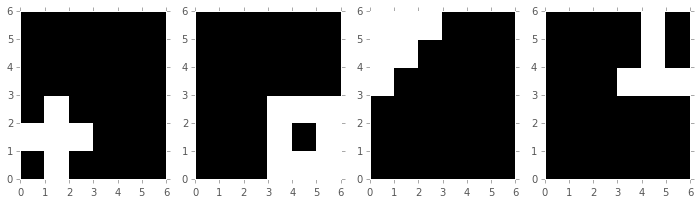

In [358]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray)  

In [359]:
Z=chain_Z[999,:,0:4].reshape(100,4)
sigma_X=chain_sigma_X[999]
sigma_A=chain_sigma_A[999]
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigma_X/sigma_A)*np.eye(4))),Z.T),X)

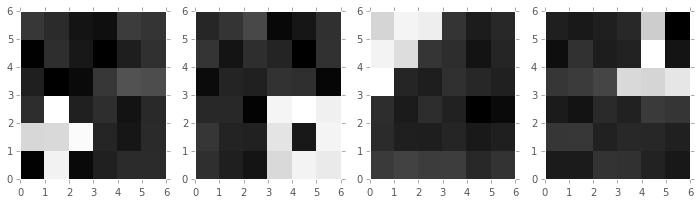

In [360]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A_inf[3,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A_inf[0,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A_inf[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A_inf[2,:].reshape(6,6),cmap=plt.cm.gray)

0.5099

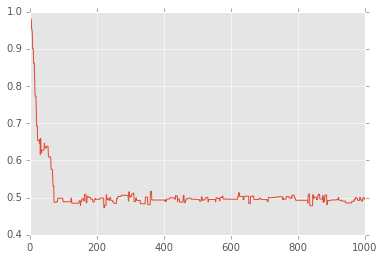

In [367]:
plt.plot(chain_sigma_X)
np.mean(chain_sigma_X)

4.9770

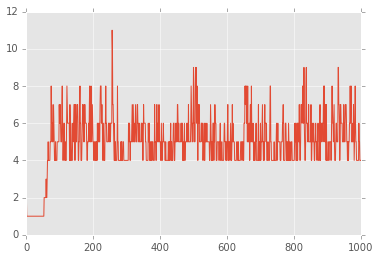

In [368]:
plt.plot(chain_K)
np.mean(chain_K)

0.9704

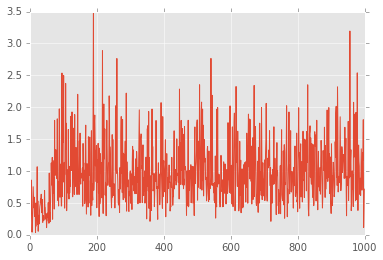

In [369]:
plt.plot(chain_alpha)
np.mean(chain_alpha)

0.4257

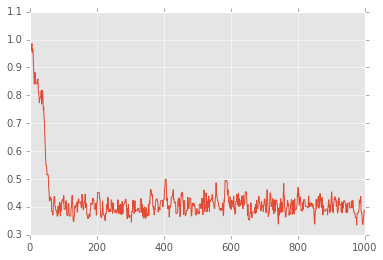

In [370]:
plt.plot(chain_sigma_A)
np.mean(chain_sigma_A)

In [ ]:
#JIT
#Cython
#C
#specific functions tht are slow